<a href="https://colab.research.google.com/github/riiswa/imed-playground/blob/main/IMED_bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install git+https://github.com/JKCooper2/gym-bandits#egg=gym-bandits
!pip install gym scipy tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JKCooper2/gym-bandits to /tmp/pip-install-e0y6cdeo/gym-bandits_fdf4efca4fb44dcf99f7785d52ce96e0
  Running command git clone --filter=blob:none --quiet https://github.com/JKCooper2/gym-bandits /tmp/pip-install-e0y6cdeo/gym-bandits_fdf4efca4fb44dcf99f7785d52ce96e0
  Resolved https://github.com/JKCooper2/gym-bandits to commit 417ed323ca2f7298a3abdad34b781fa9f13148f1
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gym
import gym_bandits

env = gym.make("BanditTenArmedGaussian-v0")
env.reset()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that

0

In [3]:
import numpy as np
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [4]:
def UCB(env, T, alpha=0.25):
  best_arm_true_mean = np.array(env.r_dist)[:, 0].max()

  regret_history = np.zeros(T)

  rewards_sum = np.zeros(env.action_space.n)
  pull_counts = np.zeros(env.action_space.n)

  for t in range(T):
    if t < env.action_space.n: # Pull each arm once
      i = t
    else:
      mu = rewards_sum / pull_counts
      indexes = mu + np.sqrt(alpha * np.log(pull_counts.max()) / 2 * pull_counts)
      i = indexes.argmax()

    _, reward, _, _ = env.step(i)
    rewards_sum[i] += reward
    pull_counts[i] += 1
    if t >= env.action_space.n:
      regret_history[t] = best_arm_true_mean -  np.array(env.r_dist)[i, 0]

  return regret_history

In [5]:
def IMED(env, T, upper_bound=5):
  def D_inf(X, mu_star):
    f = lambda v: np.mean(-np.log(1 - (X - mu_star)*v))
    return minimize_scalar(f, bounds=(0, 1/(upper_bound-mu_star)), method='bounded').fun

  best_arm_true_mean = np.array(env.r_dist)[:, 0].max()

  regret_history = np.zeros(T)

  rewards_history = np.zeros((env.action_space.n, T))
  chosen_arm = np.full(T, -1, dtype=int)
  rewards_sum = np.zeros(env.action_space.n)
  pull_counts = np.zeros(env.action_space.n, dtype=int)

  for t in range(T):
    # Pull each arm once
    if t < env.action_space.n: 
      i = t
    else:
      mu = rewards_sum / pull_counts
      mu_star = mu.max()
      _d_inf = np.array(
        [D_inf(rewards_history[i, chosen_arm == i], mu_star) for i in range(env.action_space.n)]
      )
      indexes = pull_counts * _d_inf + np.log(pull_counts)
      i = indexes.argmin()
    chosen_arm[t] = i
    _, reward, _, _ = env.step(i)
    rewards_history[i, t] = reward
    rewards_sum[i] += reward
    pull_counts[i] += 1
    regret_history[t] = best_arm_true_mean -  np.array(env.r_dist)[i, 0]

  return regret_history

100%|██████████| 10/10 [01:52<00:00, 11.23s/it]


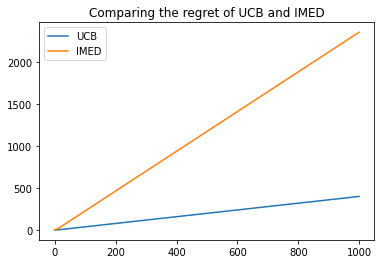

In [9]:
from tqdm import tqdm

def plot(policy, label):
  regret_history =  np.zeros(1000)
  for i in tqdm(range(10)):
    regret_history += policy()
  plt.plot(np.cumsum(regret_history / 10), label=label)

plot(lambda : UCB(env, 1000), "UCB")
plot(lambda : IMED(env, 1000), "IMED")
plt.title("Comparing the regret of UCB and IMED")
plt.legend()